In [285]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import plotly.express as px
import math
import os
import datetime

In [286]:
data_dir = 'data/'
file_name = 'ab_made_4.gzip'
df = pd.read_csv(os.path.join(data_dir, file_name), compression='gzip')

In [287]:
df.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01


In [288]:
df['datetime'] = df.timestamp.apply(datetime.datetime.fromtimestamp)
df = df.drop(['timestamp', 'date'], axis=1)

In [289]:
# избавимся от nan-ов
print(df.isna().any())
df.id_product = df.id_product.fillna(-1)
df_no_group = df[df.group.isna()]
df_ab = df[~df.group.isna()]
df_a = df_ab[df_ab['group'] == 'A']
df_b = df_ab[df_ab['group'] == 'B']

id_user        False
sum_payment    False
group           True
city           False
id_product      True
is_pay         False
datetime       False
dtype: bool


In [290]:
print(f"Datetime objects interval (outside ab-test): from {df_no_group.datetime.min()} to {df_no_group.datetime.max()}")
print(f"Datetime objects interval (A group): from {df_a.datetime.min()} to {df_a.datetime.max()}")
print(f"Datetime objects interval (B group): from {df_b.datetime.min()} to {df_b.datetime.max()}")


Datetime objects interval (outside ab-test): from 2023-04-01 03:40:17 to 2023-04-30 23:59:46
Datetime objects interval (A group): from 2023-05-01 08:48:05 to 2023-05-31 23:59:57
Datetime objects interval (B group): from 2023-05-01 01:43:46 to 2023-05-31 23:58:59


In [291]:
print(f"Num objects outside ab-test: {len(df_no_group)}")
print(f"Num object of A group: {len(df_a)}")
print(f"Num object of B group: {len(df_b)}")

Num objects outside ab-test: 25759
Num object of A group: 15389
Num object of B group: 15257


In [292]:
# проанализируем аномальные платежи на исходных данных

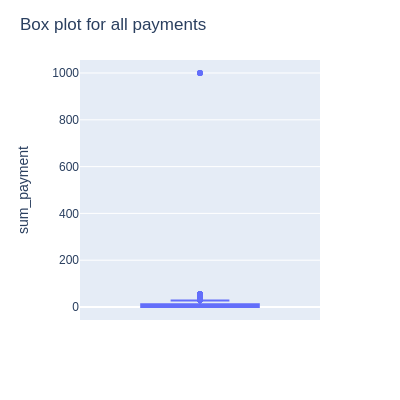

In [293]:
fig = px.box(df, y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for all payments')
fig.show("png")

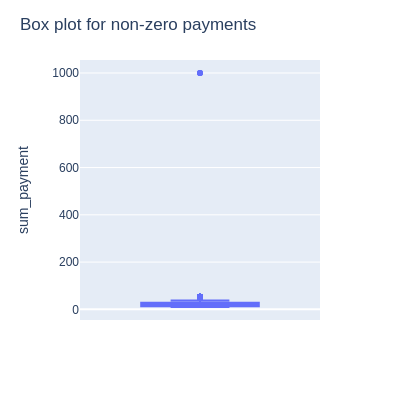

In [294]:
fig = px.box(df[df.sum_payment != 0], y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for non-zero payments')
fig.show("png")

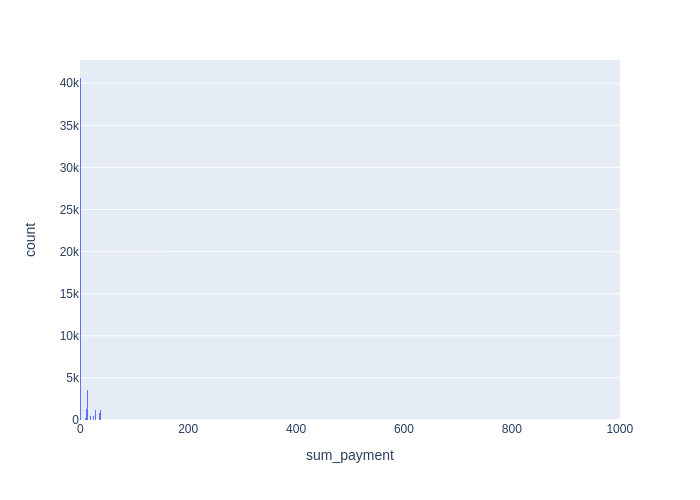

In [295]:
fig = px.histogram(df, x="sum_payment")
fig.show("png")

__Note:__ Очевидно, что есть выбросы, по сумме платежа. Очистим их из наших данных

In [296]:
print(f"Min payment: {df.sum_payment.min()}")
print(f"Max payment: {df.sum_payment.max()}")
print(f"Mean payment: {df.sum_payment.mean()}")
print(f"Median payment: {df.sum_payment.median()}")
print(f"Quantile(p=0.99) payment: {df.sum_payment.quantile(q=0.99)}")

Min payment: 0
Max payment: 1000
Mean payment: 5.955021717932808
Median payment: 0.0
Quantile(p=0.99) payment: 37.0


In [297]:
# дропаем 1% правого хвоста (аномально больщие выплаты)
df = df[df.sum_payment <= df.sum_payment.quantile(q=0.99)]

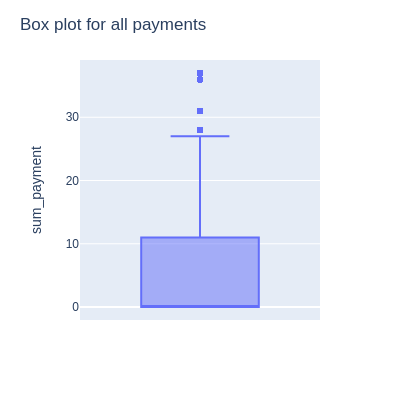

In [301]:
fig = px.box(df, y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for all payments')
fig.show("png")

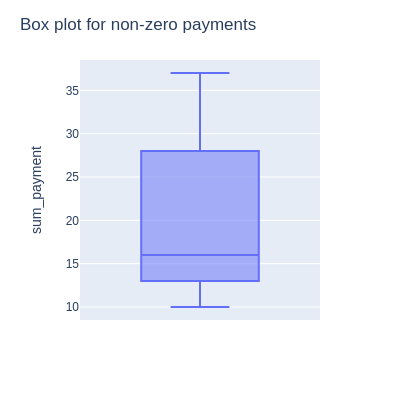

In [302]:
fig = px.box(df[df.sum_payment != 0], y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for non-zero payments')
fig.show("png")

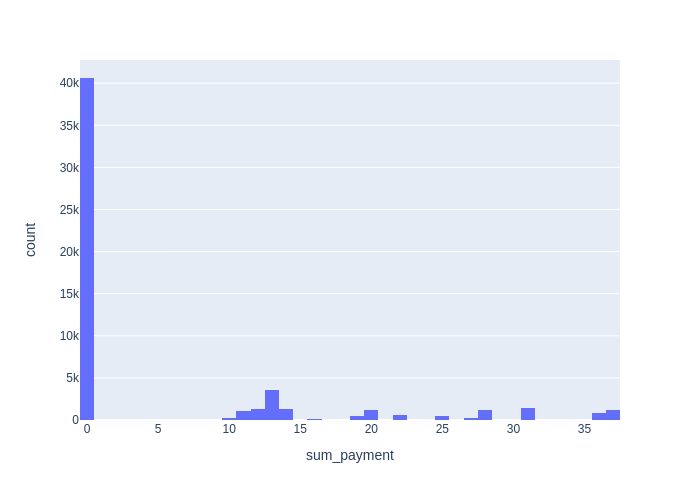

In [303]:
fig = px.histogram(df, x="sum_payment")
fig.show("png")

__Note:__ Обновим данные по группам и посмотрим сколько пользователей в каждой из двух групп

In [304]:
df_no_group = df[df.group.isna()]
df_ab = df[~df.group.isna()]
df_a = df_ab[df_ab['group'] == 'A']
df_b = df_ab[df_ab['group'] == 'B']

In [305]:
# проверка что пользователи не пересекаются по группам
assert len(set(df_a.id_user) & set(df_b.id_user)) == 0

In [306]:
print(f"Number of unique users (A group): {df_a.id_user.nunique()}")
print(f"Number of unique users (B group): {df_b.id_user.nunique()}")


Number of unique users (A group): 5976
Number of unique users (B group): 5975


In [307]:
df.head()

,id_user,sum_payment,group,city,id_product,is_pay,datetime
0,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01 09:29:33
1,user_6732,0,NaN,Рязань,1.0,0,2023-04-01 10:04:12
2,user_4199,0,NaN,Москва,3.0,0,2023-04-01 22:40:39
3,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01 11:26:20
4,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01 10:33:09


In [308]:
def filter_df_by_week(df: pd.DataFrame) -> pd.DataFrame:
    user_start_window_dt = df.groupby('id_user')['datetime'].min()
    user_end_window_dt = user_start_window_dt + datetime.timedelta(weeks=1)
    df[df.apply(lambda x: user_start_window_dt[x.id_user] <= x.datetime <= user_end_window_dt[x.id_user],
                axis=1)]
    
    return df


def calculate_week_payments(df: pd.DataFrame) -> np.ndarray:
    df = filter_df_by_week(df)
    df_total_sum_grouped = df.groupby('id_user')['sum_payment'].sum()
    return df_total_sum_grouped.values


def get_power(p_values, alpha=0.05):
    """Оценка мощности критерия, при условии, что значения p_value взяты при наличии 
    различий в сравниваемых выборках 
    """
    p_values = np.array(p_values)
    return p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

def duration_int(k: int,
                 delta_effect: float,
                 sigma_1: float,
                 sigma_2: float,
                 alpha: float = 0.05,
                 beta: float = 0.2) -> int:
    test_duration = duration(k, delta_effect, sigma_1, sigma_2, alpha, beta)
    return math.ceil(test_duration)


In [309]:
week_payments_no_group = calculate_week_payments(df_no_group)

In [310]:
alpha = 0.05
power = 0.8
beta = 1 - power
effect_percent = 10
k = 1 # for 2 groups (A and B) in formula

sigma = np.std(week_payments_no_group)
mu = np.mean(week_payments_no_group)
effect = mu * effect_percent / 100

duration_total = duration_int(k, effect, sigma, sigma, alpha, beta)
duration_group = duration_total // 2

print(f'Required total objects: {duration_total}')
print(f'Required group objects: {duration_group}')

Required total objects: 6526
Required group objects: 3263


__Note:__ Достаточна продолжительность теста в ~3200-3300 юзеров (с недельной историей) в каждой группе

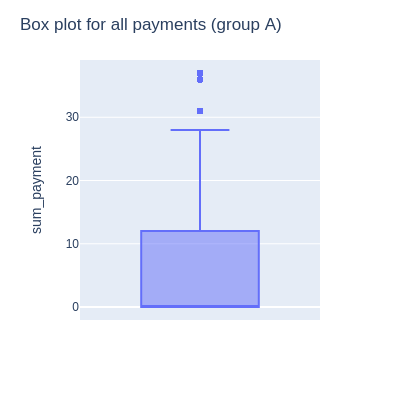

In [311]:
fig = px.box(df_a, y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for all payments (group A)')
fig.show("png")

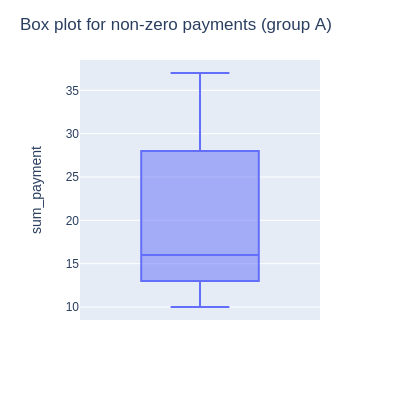

In [312]:
fig = px.box(df_a[df_a.sum_payment != 0], y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for non-zero payments (group A)')
fig.show("png")

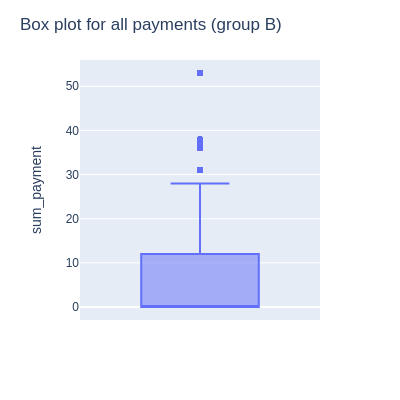

In [267]:
fig = px.box(df_a, y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for all payments (group B)')
fig.show("png")

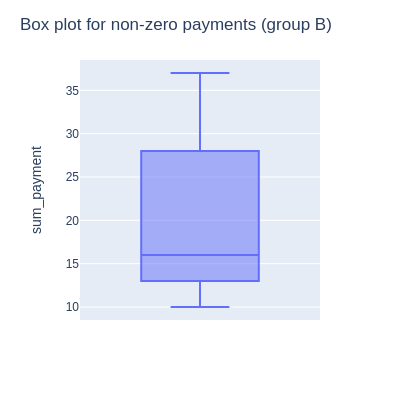

In [313]:
fig = px.box(df_b[df_b.sum_payment != 0], y="sum_payment")
fig.update_layout(autosize=False, width=400, height=400, title='Box plot for non-zero payments (group B)')
fig.show("png")

__Note:__ По графикам видно, что если рассматривать все объекты, то будут выбросы на боксплоте, тк идет смещение сильное в сторону 0. Так как много клиентов, которые ничего не приобретают на предложения. Но если посмотреть на боксплоты без нулей, то все довольно хорошо.

In [343]:
def calculate_ab_test_data(df_a: pd.DataFrame, df_b: pd.DataFrame) -> pd.DataFrame:

    start_date = min(df_a.datetime.min(), df_b.datetime.min()).date()
    end_date = max(df_a.datetime.max(), df_b.datetime.max()).date()

    dates_range = pd.date_range(start_date, end_date)

    data = []

    for date in dates_range:
        date_lim = date + datetime.timedelta(days=1)
        df_a_slice = df_a[(date <= df_a.datetime) & (df_a.datetime < date_lim)]
        df_b_slice = df_b[(date <= df_b.datetime) & (df_b.datetime < date_lim)]

        week_payments_a = calculate_week_payments(df_a_slice)
        week_payments_b = calculate_week_payments(df_b_slice)
        
        mean_week_payment_a = np.mean(week_payments_a)
        mean_week_payment_b = np.mean(week_payments_b)

        mean_week_payments_effect = mean_week_payment_b - mean_week_payment_a

        ttest = sps.ttest_ind(week_payments_a, week_payments_b)
        statistic, p_value = ttest.statistic, ttest.pvalue

        data.append((date.date(), mean_week_payment_a, mean_week_payment_b, mean_week_payments_effect, statistic, p_value))

    data_df = pd.DataFrame(data, columns=['date', 'mean_week_payment_a', 'mean_week_payment_b', 'mean_week_payments_effect', 't-statistic', 'p-value'])

    return data_df

ab_payments_df = calculate_ab_test_data(df_a, df_b)
    

In [344]:
ab_payments_df

,date,mean_week_payment_a,mean_week_payment_b,mean_week_payments_effect,t-statistic,p-value
0,2023-05-01,11.500000,3.333333,-8.166667,1.236977,0.239757
1,2023-05-02,6.000000,7.920000,1.920000,-0.493842,0.623820
2,2023-05-03,7.190476,3.324324,-3.866152,1.780862,0.078879
3,2023-05-04,5.346939,6.530612,1.183673,-0.563899,0.574138
4,2023-05-05,5.500000,6.155844,0.655844,-0.347796,0.728498
5,2023-05-06,5.085106,8.343137,3.258031,-2.114785,0.035725
6,2023-05-07,6.570093,7.054545,0.484452,-0.327701,0.743456
7,2023-05-08,4.967320,7.801527,2.834206,-2.126659,0.034317
8,2023-05-09,6.356250,6.614865,0.258615,-0.216216,0.828964
9,2023-05-10,6.680723,6.786585,0.105862,-0.081936,0.934748


In [345]:
# для последнего дня
last_day_data = ab_payments_df.tail(1)
last_day_data

,date,mean_week_payment_a,mean_week_payment_b,mean_week_payments_effect,t-statistic,p-value
30,2023-05-31,8.577001,9.635695,1.058695,-1.954661,0.050716


In [348]:
alpha = 0.05
if last_day_data['p-value'].item() < alpha:
    print('Выбираем решение, которое использовалось в группе B')
else:
    print('Выбираем решение, которое использовалось в группе A')

Выбираем решение, которое использовалось в группе A


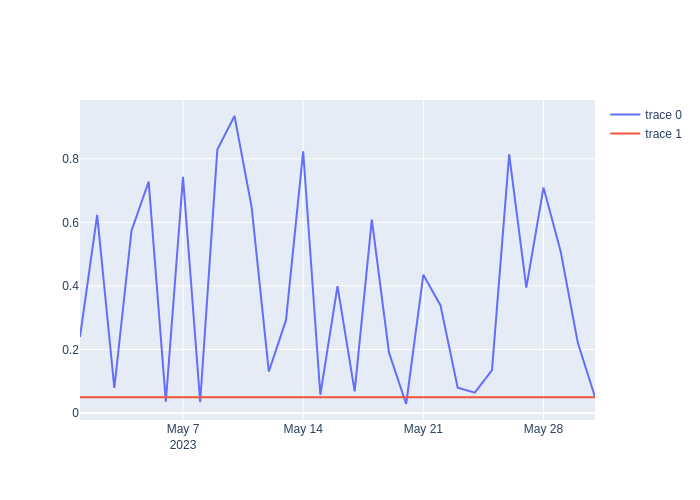

In [359]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ab_payments_df['date'], y=ab_payments_df['p-value']))
fig.add_trace(go.Scatter(x=ab_payments_df['date'], y=np.array([alpha] * len(ab_payments_df['date']))))
fig.show("png")

__Note:__ Из графика видно, что значение p-value сильно скачет, в таком случае трудно отдать предпочтение какому-то алгоритму. 